In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, normaltest, anderson
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [6]:
df_weather = pd.read_csv("dataset/WeatherEvents_2021_2022.csv")

In [7]:
df_weather["Severity"].unique()


array(['Light', 'Severe', 'Moderate', 'Heavy', 'UNK', 'Other'],
      dtype=object)

In [8]:
df_weather["Severity"].value_counts()


Severity
Light       1328637
Severe       561754
Moderate     348675
UNK           60499
Heavy         52820
Other           300
Name: count, dtype: int64

In [ ]:
# Dataset de atrasos em voos
df_flights = pd.read_csv("dataset/flight-delay-dataset-2021-2022.csv")

# Dataset de eventos climáticos
df_weather = pd.read_csv("dataset/WeatherEvents_2021_2022.csv")

print(" Atrasos em Voos")
display(df_flights.head())

print("\n Eventos Climáticos")
display(df_weather.head())

 Atrasos em Voos


,FlightDate,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,...,DestState,DestStateName,DepDel15,DepTimeBlk,TaxiOut,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrTimeBlk
0,2021-01-01,MSY,HOU,0.0,0.0,715,713.0,0.0,-2.0,822.0,...,TX,Texas,0.0,0700-0759,9.0,4.0,835,-13.0,0.0,0800-0859
1,2021-01-01,SAV,MIA,0.0,0.0,1911,1901.0,0.0,-10.0,2025.0,...,FL,Florida,0.0,1900-1959,11.0,5.0,2044,-19.0,0.0,2000-2059
2,2021-01-01,DEN,IND,0.0,0.0,1010,1029.0,19.0,19.0,1452.0,...,IN,Indiana,1.0,1000-1059,15.0,5.0,1442,10.0,0.0,1400-1459
3,2021-01-01,ATL,EWR,0.0,0.0,1354,1350.0,0.0,-4.0,1548.0,...,NJ,New Jersey,0.0,1300-1359,14.0,7.0,1554,-6.0,0.0,1500-1559
4,2021-01-01,MDW,RSW,0.0,0.0,950,947.0,0.0,-3.0,1350.0,...,FL,Florida,0.0,0900-0959,23.0,2.0,1340,10.0,0.0,1300-1359



 Eventos Climáticos


,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),AirportCode,City,State
0,W-1973,Snow,Light,2021-01-06 00:15:00,2021-01-06 00:35:00,K04V,Saguache,CO
1,W-1974,Snow,Light,2021-01-10 02:15:00,2021-01-10 02:35:00,K04V,Saguache,CO
2,W-1975,Storm,Severe,2021-01-14 04:35:00,2021-01-14 04:55:00,K04V,Saguache,CO
3,W-1976,Storm,Severe,2021-01-14 20:35:00,2021-01-14 21:15:00,K04V,Saguache,CO
4,W-1977,Storm,Severe,2021-01-14 21:35:00,2021-01-14 21:55:00,K04V,Saguache,CO


In [7]:
# 📊 Contagem de Cancelados e Desviados
df_flights[["Cancelled", "Diverted"]].apply(lambda col: (col == 1).sum())


Cancelled    21777
Diverted      2233
dtype: int64

In [15]:
# Mostrar os totais com formatação
eventos = df_flights[["Cancelled", "Diverted", "Delayed"]].apply(lambda col: (col == 1).sum()).reset_index()
eventos.columns = ["Tipo de Evento", "Total"]
display(eventos)


,Tipo de Evento,Total
0,Cancelled,21777
1,Diverted,2233
2,Delayed,164944


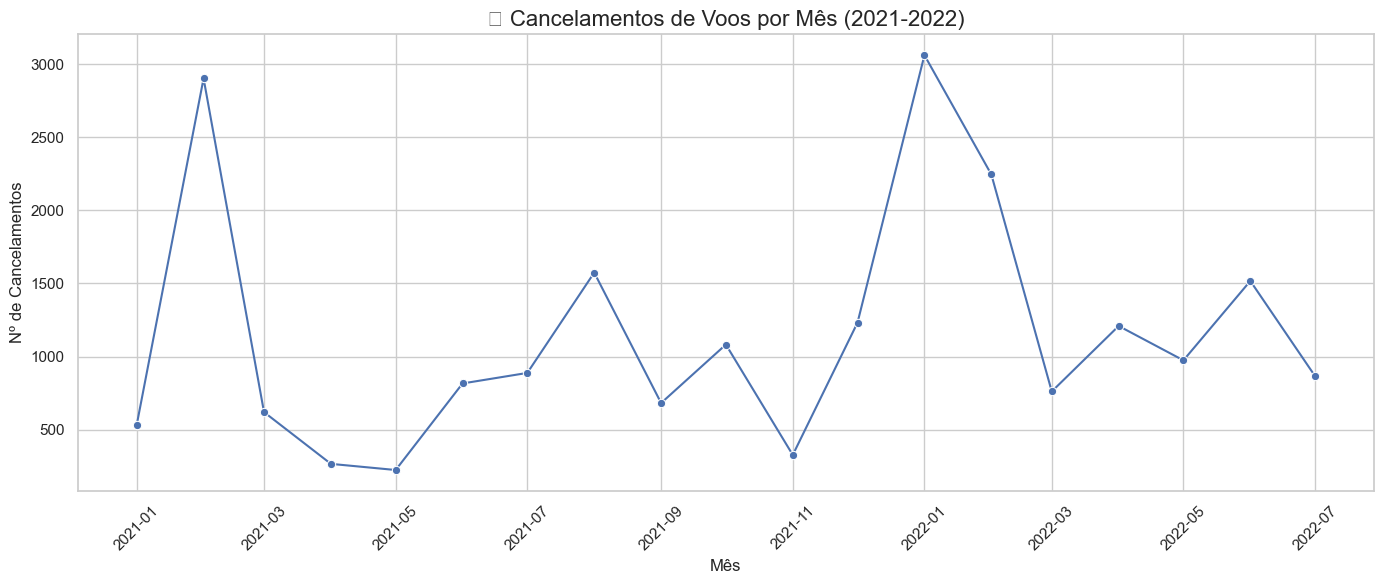

In [8]:
# ===========================================
# 📈 Série Temporal: Cancelamentos por Mês
# ===========================================

# Garantir que a coluna de data está em formato datetime
df_flights["FlightDate"] = pd.to_datetime(df_flights["FlightDate"])

# Criar uma coluna de ano-mês
df_flights["YearMonth"] = df_flights["FlightDate"].dt.to_period("M").astype(str)

# Agrupar por mês e contar cancelamentos
cancelamentos_mensais = df_flights.groupby("YearMonth")["Cancelled"].sum().reset_index()

# Converter para datetime para usar como eixo x
cancelamentos_mensais["YearMonth"] = pd.to_datetime(cancelamentos_mensais["YearMonth"])

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=cancelamentos_mensais, x="YearMonth", y="Cancelled", marker="o")
plt.title("📉 Cancelamentos de Voos por Mês (2021-2022)", fontsize=16)
plt.xlabel("Mês")
plt.ylabel("Nº de Cancelamentos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

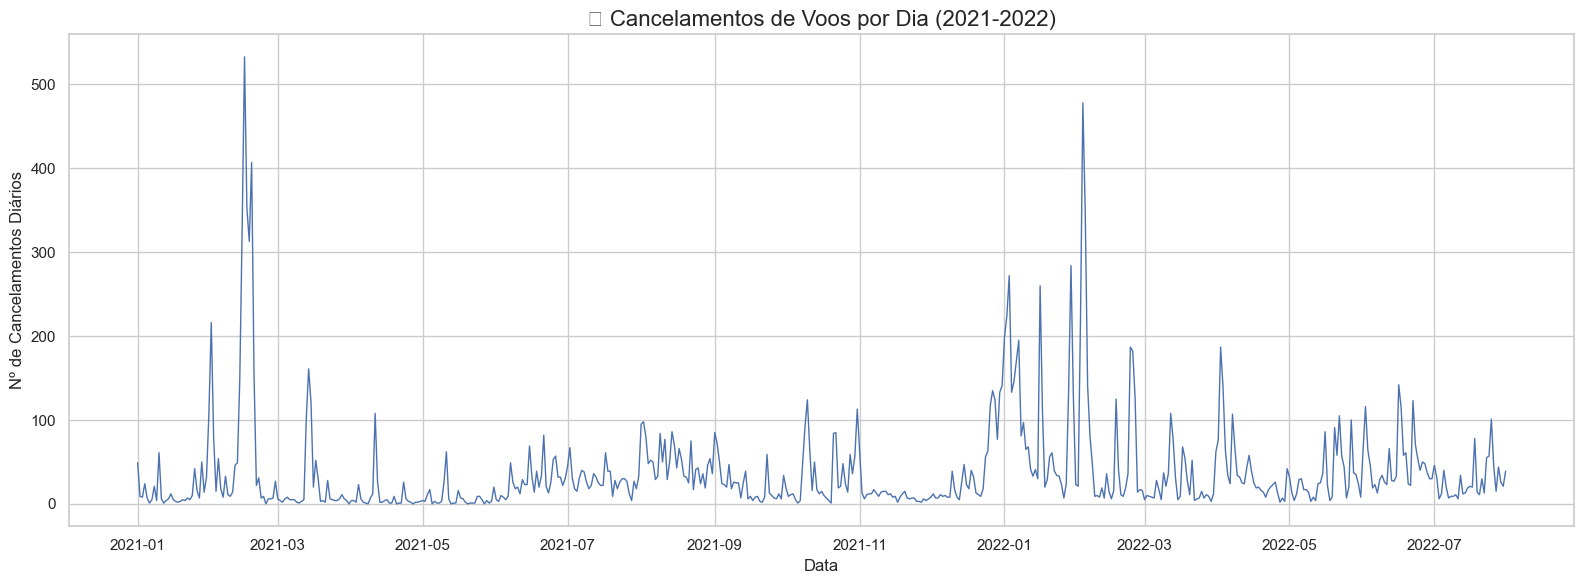

In [9]:
# ===========================================
# 📅 Série Temporal: Cancelamentos por Dia
# ===========================================

# Agrupar por dia e contar cancelamentos
cancelamentos_diarios = df_flights.groupby("FlightDate")["Cancelled"].sum().reset_index()

# Garantir formato datetime
cancelamentos_diarios["FlightDate"] = pd.to_datetime(cancelamentos_diarios["FlightDate"])

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(data=cancelamentos_diarios, x="FlightDate", y="Cancelled", linewidth=1)
plt.title("📉 Cancelamentos de Voos por Dia (2021-2022)", fontsize=16)
plt.xlabel("Data")
plt.ylabel("Nº de Cancelamentos Diários")
plt.tight_layout()
plt.grid(True)
plt.show()

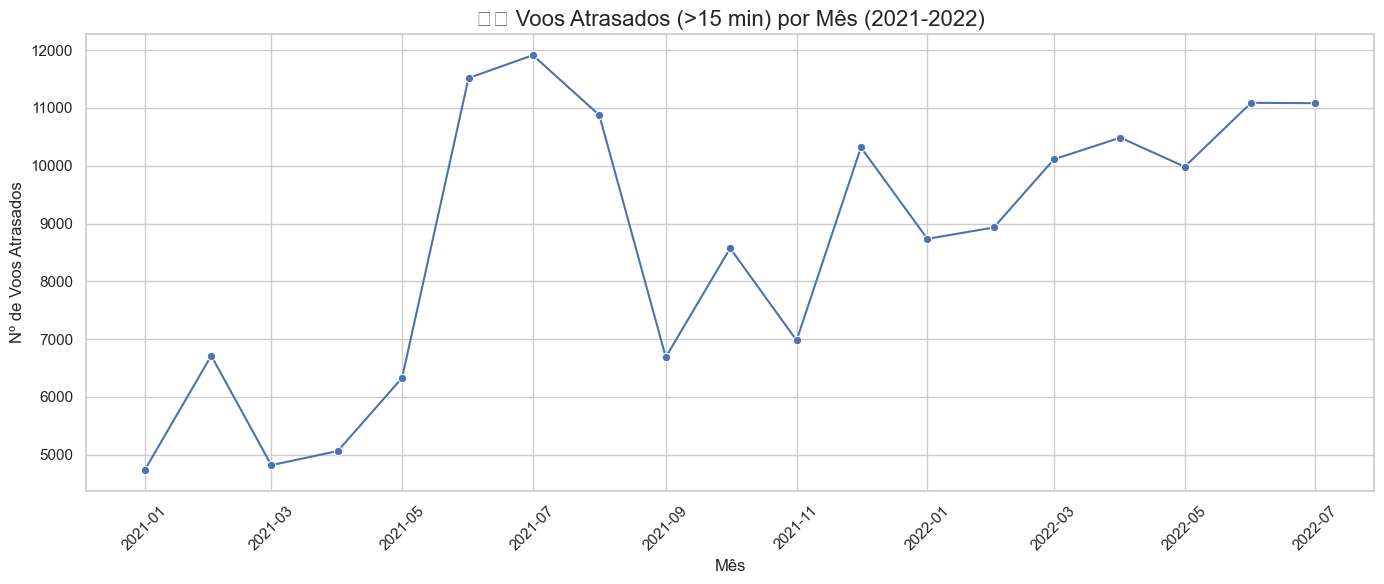

In [11]:
# ===========================================
# 🗓️ Série Temporal: Atrasos por Mês (> 15 min)
# ===========================================

# Criar flag binária para atrasos significativos
df_flights["Delayed"] = df_flights["ArrDelay"] > 15

# Agrupar por mês
atrasos_mensais = df_flights.groupby("YearMonth")["Delayed"].sum().reset_index()
atrasos_mensais["YearMonth"] = pd.to_datetime(atrasos_mensais["YearMonth"])

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=atrasos_mensais, x="YearMonth", y="Delayed", marker="o")
plt.title("✈️ Voos Atrasados (>15 min) por Mês (2021-2022)", fontsize=16)
plt.xlabel("Mês")
plt.ylabel("Nº de Voos Atrasados")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

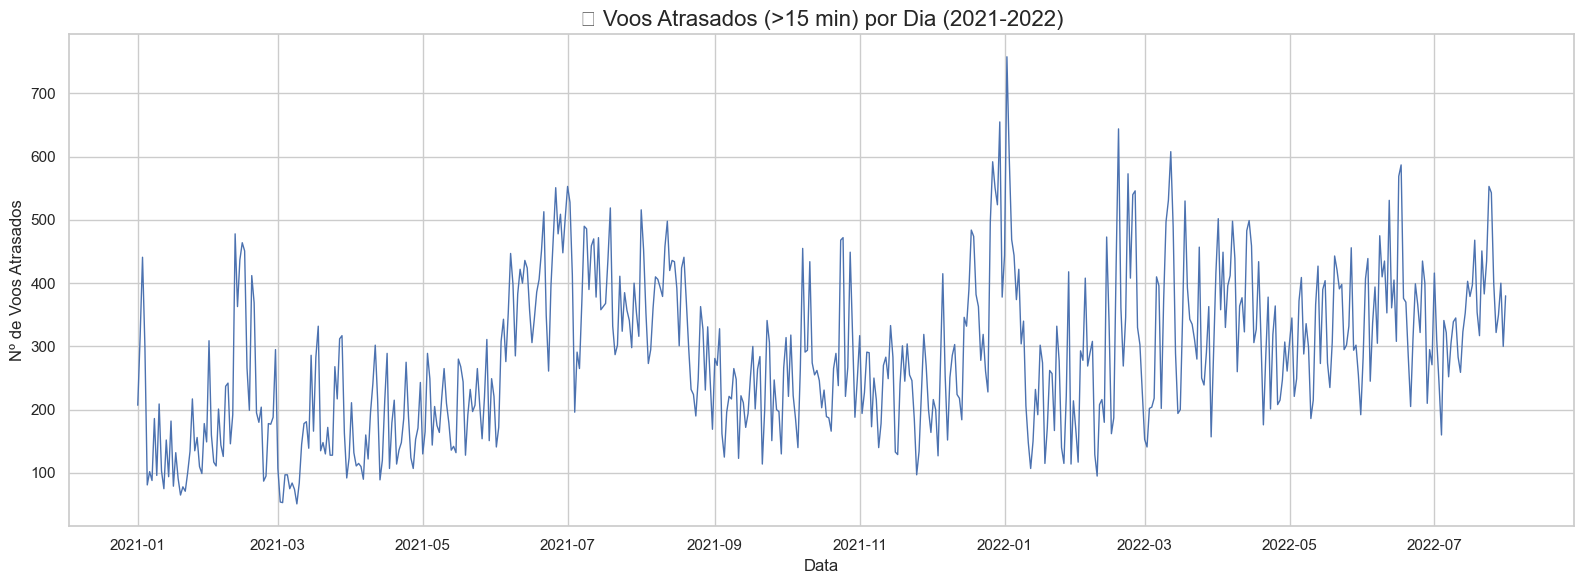

In [12]:
# ===========================================
# 📅 Série Temporal: Atrasos por Dia (> 15 min)
# ===========================================

# Agrupar por dia
atrasos_diarios = df_flights.groupby("FlightDate")["Delayed"].sum().reset_index()
atrasos_diarios["FlightDate"] = pd.to_datetime(atrasos_diarios["FlightDate"])

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(data=atrasos_diarios, x="FlightDate", y="Delayed", linewidth=1)
plt.title("📅 Voos Atrasados (>15 min) por Dia (2021-2022)", fontsize=16)
plt.xlabel("Data")
plt.ylabel("Nº de Voos Atrasados")
plt.tight_layout()
plt.grid(True)
plt.show()

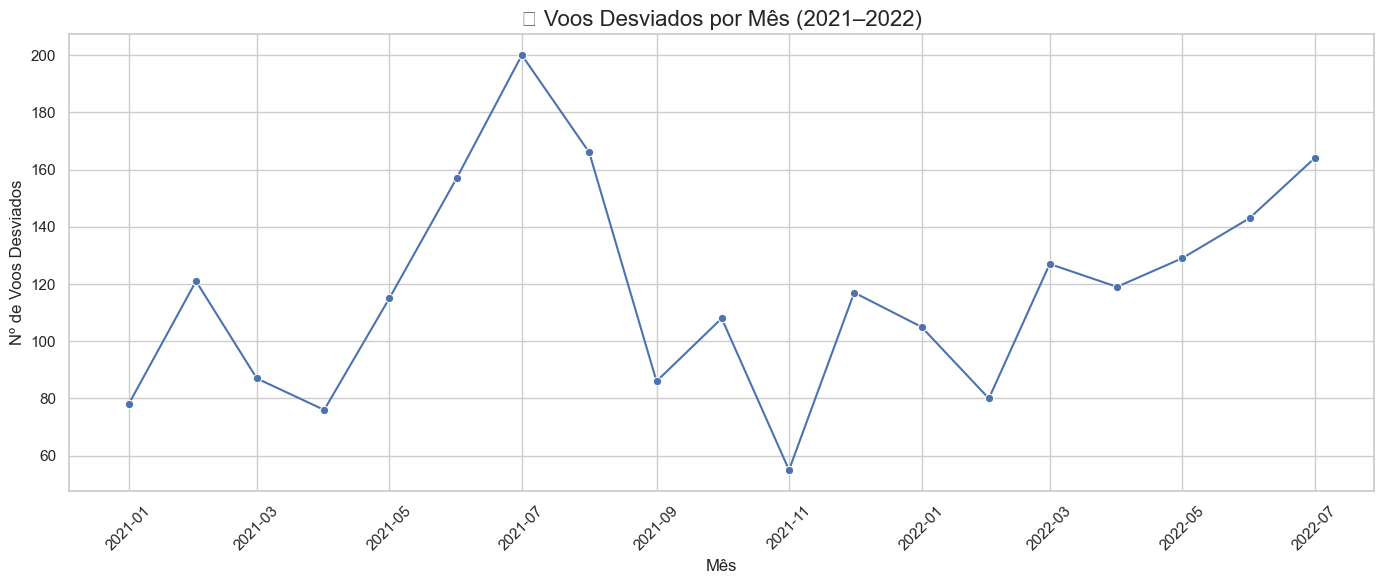

In [16]:
# ===========================================
# 🔄 Série Temporal: Voos Desviados por Mês
# ===========================================

# Agrupar por mês e somar desvios
desvios_mensais = df_flights.groupby("YearMonth")["Diverted"].sum().reset_index()
desvios_mensais["YearMonth"] = pd.to_datetime(desvios_mensais["YearMonth"])

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=desvios_mensais, x="YearMonth", y="Diverted", marker="o")
plt.title("🔄 Voos Desviados por Mês (2021–2022)", fontsize=16)
plt.xlabel("Mês")
plt.ylabel("Nº de Voos Desviados")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

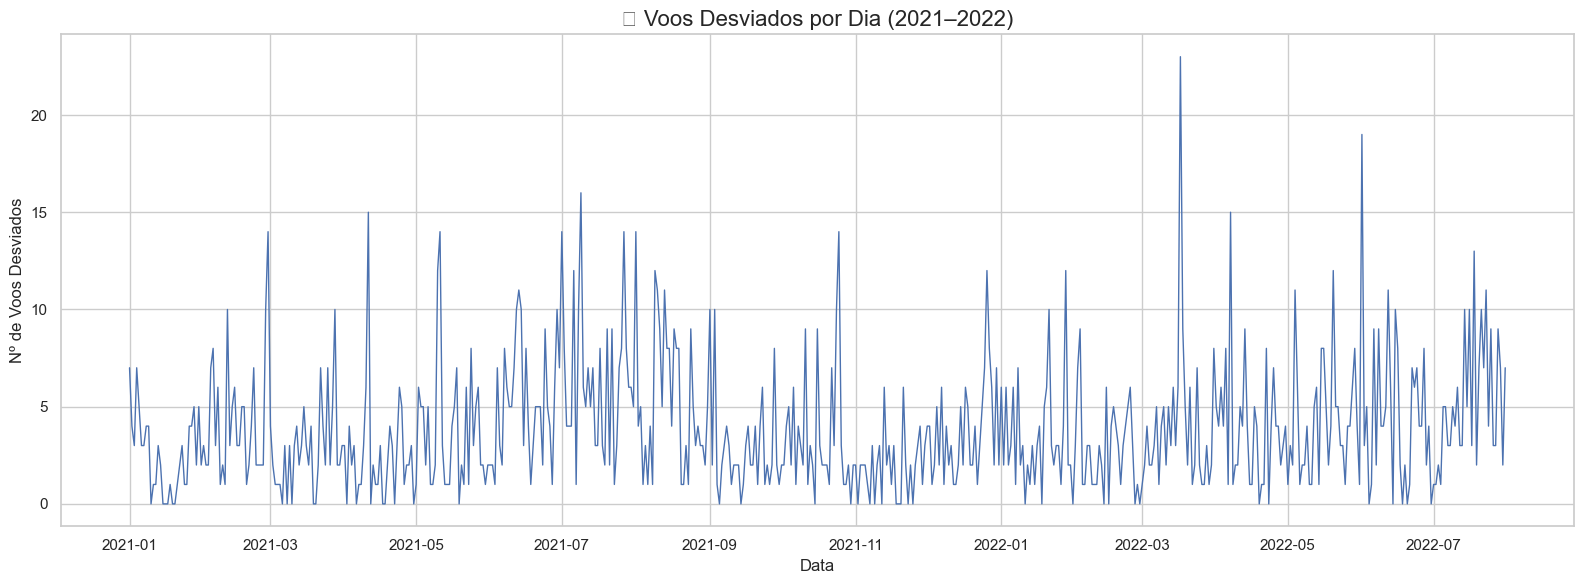

In [19]:
# ===========================================
# 📅 Série Temporal: Voos Desviados por Dia
# ===========================================

# Agrupar por dia e somar desvios
desvios_diarios = df_flights.groupby("FlightDate")["Diverted"].sum().reset_index()
desvios_diarios["FlightDate"] = pd.to_datetime(desvios_diarios["FlightDate"])

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(data=desvios_diarios, x="FlightDate", y="Diverted", linewidth=1)
plt.title("📅 Voos Desviados por Dia (2021–2022)", fontsize=16)
plt.xlabel("Data")
plt.ylabel("Nº de Voos Desviados")
plt.tight_layout()
plt.grid(True)
plt.show()

In [9]:
# Mapear severidades relevantes e agrupar outras
severity_clean_map = {
    "Severe": "Severe",
    "Moderate": "Moderate",
    "Heavy": "Severe",    # Agrupar com Severe
    "Light": "Ignore",
    "UNK": "Ignore",
    "Other": "Ignore"
}

# Nova coluna com severidade filtrada
df_weather["CleanSeverity"] = df_weather["Severity"].map(severity_clean_map)


In [10]:
df_weather["CleanSeverity"].value_counts()


CleanSeverity
Ignore      1389436
Severe       614574
Moderate     348675
Name: count, dtype: int64

In [17]:
# Filtrar eventos Moderate e Severe apenas
df_weather_filtrado = df_weather[df_weather["CleanSeverity"].isin(["Moderate", "Severe"])]

# Contar eventos relevantes por dia
# Criar coluna de data (sem horas)
df_weather_filtrado["EventDate"] = pd.to_datetime(df_weather_filtrado["StartTime(UTC)"]).dt.date

# Agrupar por dia
weather_daily_count = df_weather_filtrado.groupby("EventDate").size().reset_index(name="NumWeatherEvents")



In [18]:
# Atribuir uma pontuação à severidade
severity_score_map = {
    "Moderate": 2,
    "Severe": 3
}
df_weather_filtrado["SeverityScore"] = df_weather_filtrado["CleanSeverity"].map(severity_score_map)

# Soma de pontuação de severidade por dia
weather_daily_score = df_weather_filtrado.groupby("EventDate")["SeverityScore"].sum().reset_index()



In [19]:
weather_binary = df_weather_filtrado[["EventDate"]].drop_duplicates()
weather_binary["HasWeatherEvent"] = 1
